In [1]:
from imports import *
from exactDiagMethods import build_exact_diag_hamiltonian, perform_exact_diag
from globalMethods import  build_initial_states, output_results
from vqteMethods import hamiltonian_generation, perform_vqte

In [2]:

def main():
    # Initialize the simulation parameters
    N = 1
    gamma= 0.1
    eps = 1
    mu_L= 0.9
    mu_R= 1.1
    T_L = 100
    T_R= 1
    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)
    J = 1
  
    time = 40.0
    dt = 0.1
    nt = int(time/dt)
    exact_diag_ham= build_exact_diag_hamiltonian(N,J, eps)
    print("Exact Ham", exact_diag_ham)

   
    ham_real, ham_imag = hamiltonian_generation(N, eps, gamma, F_L, F_R,J)
    print("Ham imag", ham_imag)
    print("Ham real", ham_real)

    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real,N)
    exact_diag_results, time_points = perform_exact_diag(gamma, F_L, F_R, dt, nt, exact_diag_init_state,exact_diag_ham,N,eps)

    print("VQTE initial state", vqte_init_state)
    print("Exact initial state:",exact_diag_init_state)
    vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values,N)
    
    # # Output results
    output_results(vqte_results, exact_diag_results, time, nt, time_points)

Exact Ham [[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Ham imag SparsePauliOp(['XX', 'YY', 'II', 'ZI', 'ZI', 'IZ', 'IZ'],
              coeffs=[-0.05      +0.j,  0.05      +0.j,  0.1       +0.j, -0.0250125 +0.j,
 -0.0249875 +0.j, -0.02375104+0.j, -0.02624896+0.j])
Ham real SparsePauliOp(['ZI', 'IZ', 'XY', 'YX'],
              coeffs=[ 0.5+0.j, -0.5+0.j,  1. +0.j,  1. +0.j])
VQTE initial state Statevector([ 1.0000000e+00+4.89858720e-16j,
             -1.2246468e-16-2.99951957e-32j,
             -2.4492936e-16-2.99951957e-32j,
             -1.2246468e-16+2.99951957e-32j],
            dims=(2, 2))
Exact initial state: [[ 1.0000000e+00+4.89858720e-16j -2.4492936e-16-2.99951957e-32j]
 [-1.2246468e-16-2.99951957e-32j -1.2246468e-16+2.99951957e-32j]]
Initial expectation values:
  Qubit 0: 0.0000
Step 1 out of 400
Step 2 out of 400
Step 3 out of 400
Step 4 out of 400
Step 5 out of 400
Step 6 out of 400
Step 7 out of 400
Step 8 out of 400
Step 9 out of 400
Step 10 out of 400
Step 11 out of 400
Step 12 ou

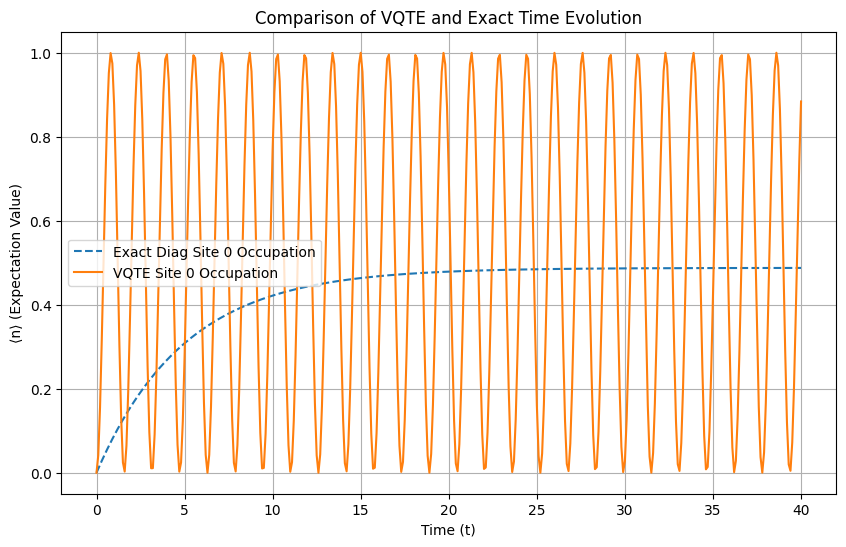

In [3]:
main()